# Scene Recognition with Deep Learning
For this project we are going to focus on scene classification for 15 scene types with a state-of-the-art approach: deep learning. The task is also known as image classification. 

### Preparation

We'll import the required functions and set up GPU computation.


In [4]:
import os

import torch

from vision.runner import Trainer, MultiLabelTrainer
from vision.optimizer import get_optimizer
from vision.simple_net import SimpleNet
from vision.simple_net_final import SimpleNetFinal
from vision.my_resnet import MyResNet18
from vision.multilabel_resnet import MultilabelResNet18
from vision.data_transforms import (
    get_fundamental_transforms,
    get_fundamental_normalization_transforms,
    get_fundamental_augmentation_transforms,
    get_all_transforms,
)
from vision.stats_helper import compute_mean_and_std
from vision.confusion_matrix import (
    generate_confusion_data,
    generate_confusion_matrix,
    plot_confusion_matrix,
    get_pred_images_for_target,
    generate_and_plot_confusion_matrix,
    generate_and_plot_accuracy_table,
)
from vision.dl_utils import save_trained_model_weights

%load_ext autoreload
%autoreload 2

In [6]:
is_cuda = True
is_cuda = (
    is_cuda and torch.cuda.is_available()
)  # will turn off cuda if the machine doesnt have a GPU
print("Cuda available: ", is_cuda)

Cuda available:  False


In [7]:
is_apple_silicon = True
is_apple_silicon = is_apple_silicon and torch.backends.mps.is_available()
print(f"Apple silicon available: {is_apple_silicon}")

Apple silicon available: True


In [8]:
data_path = "./data/" if not use_colab else "./data/"
model_path = "../model_checkpoints/" if not use_colab else "./model_checkpoints/"

## Part 1: SimpleNet
To train a network in PyTorch, we need 4 components:
1. **Dataset** - an object which can load the data and labels given an index.
2. **Model** - an object that contains the network architecture definition.
3. **Loss function** - a function that measures how far the network output is from the ground truth label.
4. **Optimizer** - an object that optimizes the network parameters to reduce the loss value.

### Part 1.1: Datasets
Now let's create the **Datasets** object to be used later. We have to load each image as well as it's classification label. The key idea is to store the paths to all the images in your dataset, and then be able to provide the image file path and its ground truth class id when given the index of a data example. We will map the scene names (text) into indices 0 to 14 in the image loader.


In [ ]:
inp_size = (64, 64)

### Data transforms
1. Resize the input image to the desired shape;
2. Convert it to a tensor.

### Part 1.2: Model
The data is ready! Now we are preparing to move to the actual core of deep learning: the architecture. 

In [12]:
simple_model = SimpleNet()

### Loss function

In [13]:
print(simple_model)

SimpleNet(
  (conv_layers): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=500, out_features=100, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=100, out_features=15, bias=True)
  )
  (loss_criterion): CrossEntropyLoss()
)


### Optimizer


In [ ]:
optimizer_config = {"optimizer_type": "adam", "lr": 1e-3, "weight_decay": 1e-5}

In [15]:
optimizer = get_optimizer(simple_model, optimizer_config)

### Part 1.3: Trainer

In [17]:
# re-init the model so that the weights are all random
simple_model_base = SimpleNet()
optimizer = get_optimizer(simple_model_base, optimizer_config)

trainer = Trainer(
    data_dir=data_path,
    model=simple_model_base,
    optimizer=optimizer,
    model_dir=os.path.join(model_path, "simple_net"),
    train_data_transforms=get_fundamental_transforms(inp_size),
    val_data_transforms=get_fundamental_transforms(inp_size),
    batch_size=32,
    load_from_disk=False,
    cuda=is_cuda,
    mps=is_apple_silicon,
)

In [18]:
%%time
trainer.run_training_loop(num_epochs=30)

Epoch:1 Train Loss:2.6602 Val Loss: 2.6748 Train Accuracy: 0.1062 Validation Accuracy: 0.1060
Epoch:2 Train Loss:2.3362 Val Loss: 2.2851 Train Accuracy: 0.2291 Validation Accuracy: 0.2487
Epoch:3 Train Loss:2.1360 Val Loss: 2.1612 Train Accuracy: 0.2921 Validation Accuracy: 0.2733
Epoch:4 Train Loss:1.9887 Val Loss: 2.0788 Train Accuracy: 0.3243 Validation Accuracy: 0.2940
Epoch:5 Train Loss:1.8999 Val Loss: 1.9751 Train Accuracy: 0.3564 Validation Accuracy: 0.3407
Epoch:6 Train Loss:1.8176 Val Loss: 1.9626 Train Accuracy: 0.3896 Validation Accuracy: 0.3393
Epoch:7 Train Loss:1.7436 Val Loss: 1.8647 Train Accuracy: 0.4221 Validation Accuracy: 0.3687
Epoch:8 Train Loss:1.6417 Val Loss: 1.7705 Train Accuracy: 0.4536 Validation Accuracy: 0.4087
Epoch:9 Train Loss:1.6067 Val Loss: 1.7481 Train Accuracy: 0.4596 Validation Accuracy: 0.4040
Epoch:10 Train Loss:1.5525 Val Loss: 1.7391 Train Accuracy: 0.4801 Validation Accuracy: 0.4220
Epoch:11 Train Loss:1.5130 Val Loss: 1.7976 Train Accuracy:

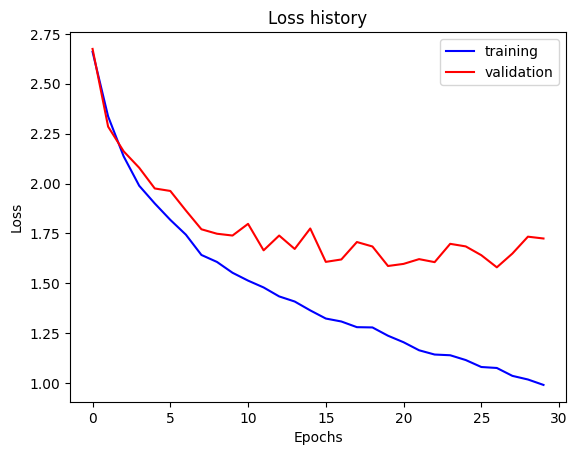

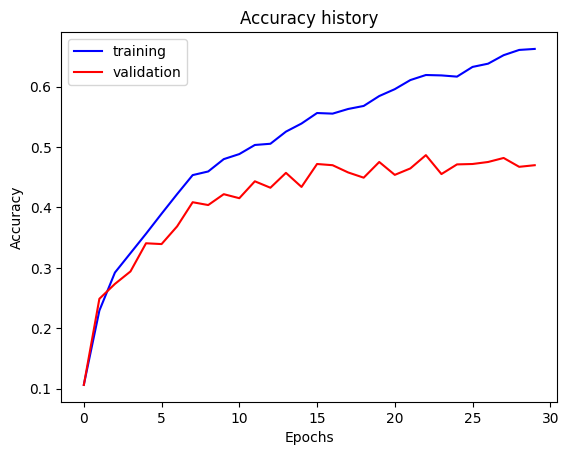

In [19]:
trainer.plot_loss_history()
trainer.plot_accuracy()

In [20]:
train_accuracy = trainer.train_accuracy_history[-1]
validation_accuracy = trainer.validation_accuracy_history[-1]
print(
    "Train Accuracy = {}; Validation Accuracy = {}".format(
        train_accuracy, validation_accuracy
    )
)

Train Accuracy = 0.6626465661641541; Validation Accuracy = 0.47


### Save the model for your SimpleNet

In [21]:
save_trained_model_weights(simple_model_base, out_dir="./")

## Part 2: SimpleNet with additional modifications

### Part 2.1: Problem 1 We don’t have enough training data. Let’s “jitter.”

We are going to increase our amount of training data by left-right mirroring and color jittering the training images during the learning process.

### Part 2.2: Problem 2 The images aren’t zero-centered and variance-normalized.

We are going to "zero-center" and "normalize" the dataset so that each entry has zero mean and the overall standard deviation is 1. 

In [ ]:
dataset_mean, dataset_std = compute_mean_and_std(data_path)

In [24]:
print("Dataset mean = {}, standard deviation = {}".format(dataset_mean, dataset_std))

Dataset mean = 0.45547485663755616, standard deviation = 0.253163276340882


In [26]:
inp_size = (64, 64)

### Part 2.3-2.5: Problem 3 ~ 5: Modify the network.

In [28]:
simple_model_final = SimpleNetFinal()
print(simple_model_final)

SimpleNetFinal(
  (conv_layers): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
    (5): Conv2d(10, 15, kernel_size=(5, 5), stride=(1, 1))
    (6): BatchNorm2d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(15, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=500, out_features=100, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=100, out_features

In [ ]:
optimizer_config = {"optimizer_type": "adam", "lr": 1e-3, "weight_decay": 1e-5}

In [30]:
simple_model_final = SimpleNetFinal()
optimizer = get_optimizer(simple_model_final, optimizer_config)

trainer = Trainer(
    data_dir=data_path,
    model=simple_model_final,
    optimizer=optimizer,
    model_dir=os.path.join(model_path, "simple_model_final"),
    train_data_transforms=get_all_transforms(inp_size, [dataset_mean], [dataset_std]),
    val_data_transforms=get_fundamental_normalization_transforms(
        inp_size, [dataset_mean], [dataset_std]
    ),
    batch_size=32,
    load_from_disk=False,
    cuda=is_cuda,
    mps=is_apple_silicon,
)

In [31]:
%%time
trainer.run_training_loop(num_epochs=30)

Epoch:1 Train Loss:2.4968 Val Loss: 2.2459 Train Accuracy: 0.1698 Validation Accuracy: 0.2353
Epoch:2 Train Loss:2.1077 Val Loss: 2.0561 Train Accuracy: 0.2881 Validation Accuracy: 0.2893
Epoch:3 Train Loss:1.8995 Val Loss: 1.8843 Train Accuracy: 0.3658 Validation Accuracy: 0.3467
Epoch:4 Train Loss:1.7662 Val Loss: 1.7687 Train Accuracy: 0.4151 Validation Accuracy: 0.3967
Epoch:5 Train Loss:1.6202 Val Loss: 1.7121 Train Accuracy: 0.4613 Validation Accuracy: 0.4067
Epoch:6 Train Loss:1.5267 Val Loss: 1.5239 Train Accuracy: 0.4787 Validation Accuracy: 0.4893
Epoch:7 Train Loss:1.4417 Val Loss: 1.4579 Train Accuracy: 0.5203 Validation Accuracy: 0.5013
Epoch:8 Train Loss:1.3827 Val Loss: 1.4726 Train Accuracy: 0.5333 Validation Accuracy: 0.5073
Epoch:9 Train Loss:1.3461 Val Loss: 1.3754 Train Accuracy: 0.5561 Validation Accuracy: 0.5440
Epoch:10 Train Loss:1.2608 Val Loss: 1.3970 Train Accuracy: 0.5772 Validation Accuracy: 0.5293
Epoch:11 Train Loss:1.2243 Val Loss: 1.2920 Train Accuracy:

Similar to Part 1, now plot out the loss and accuracy history.

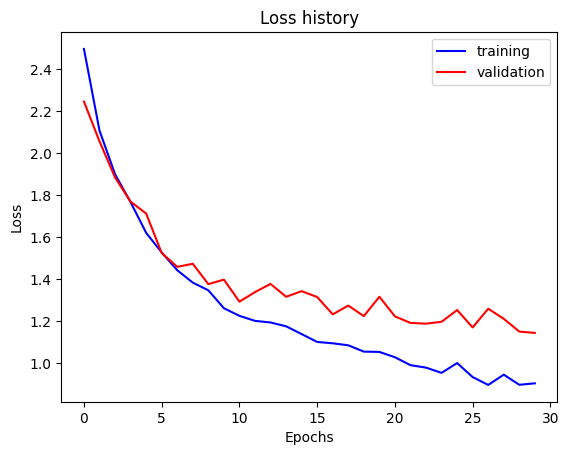

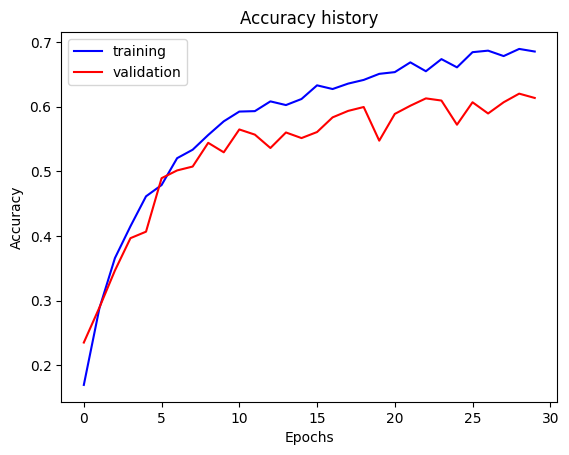

In [32]:
trainer.plot_loss_history()
trainer.plot_accuracy()

In [33]:
train_accuracy = trainer.train_accuracy_history[-1]
validation_accuracy = trainer.validation_accuracy_history[-1]
print(
    "Train Accuracy = {}; Validation Accuracy = {}".format(
        train_accuracy, validation_accuracy
    )
)

Train Accuracy = 0.6850921273031826; Validation Accuracy = 0.6133333333333333


### Save the model for your SimpleNetFinal

In [34]:
save_trained_model_weights(simple_model_final, out_dir="./")

### Part 2.6: Analysis using confusion matrix
A confusion matrix is a helpful tool for visualizing the performance of classification algorithms. Each row of the matrix represents the instances in a predicted class, while each column represents the instances in an actual class. The confusion matrix counts the number of instances of a given (target, prediction) pair. We are able to use this to understand the classification behaviour.

A confusion matrix can also be normalized by dividing each row by the total number of instances of the target class. This is helpful for comparing between large and small datasets, as well as when there is significant class imbalance.

In [36]:
%%time
targets, predictions, class_labels = generate_confusion_data(
    trainer.model, trainer.val_dataset, use_cuda=is_cuda
)

CPU times: user 873 ms, sys: 79.5 ms, total: 952 ms
Wall time: 1.13 s


In [37]:
confusion_matrix = generate_confusion_matrix(targets, predictions, len(class_labels))

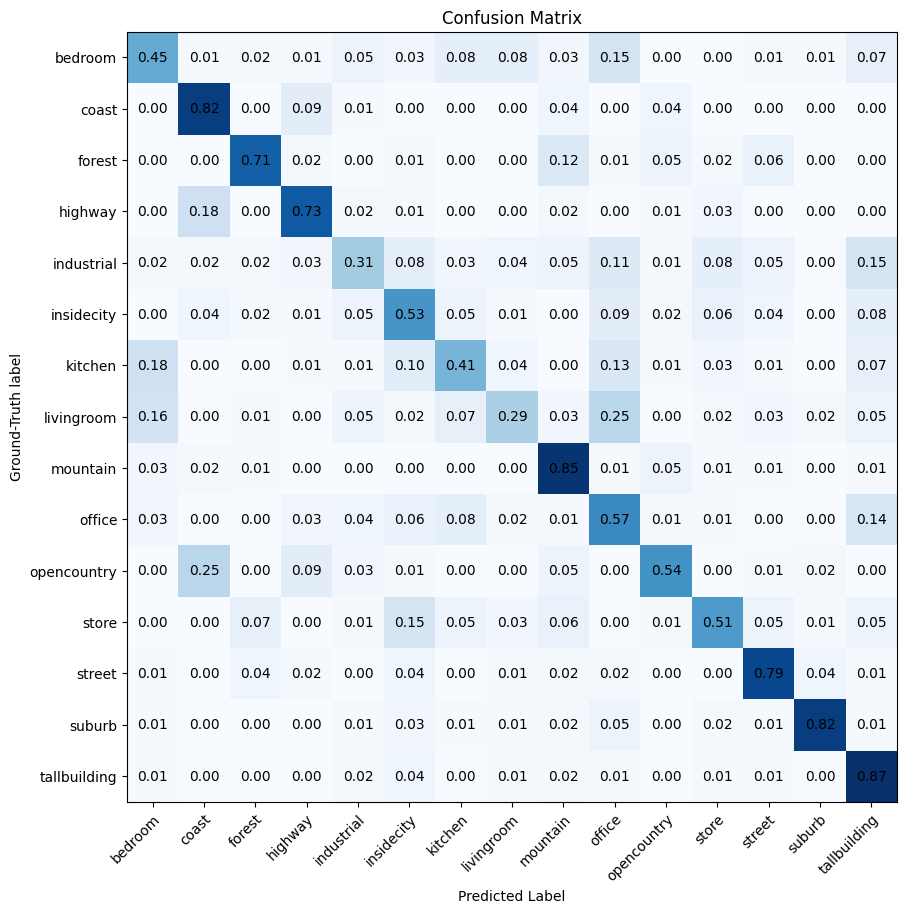

In [38]:
plot_confusion_matrix(confusion_matrix, class_labels)

## Part 3: ResNet
You can see that after the above adjustment, our model performance increases in terms of testing accuracy. Although the training accuracy drops, now it's closer to the testing values and that's more natural in terms of performance. But we are not satisfied with the final performance yet. Our model, in the end, is still a 2-layer SimpleNet and it might be capable of capturing some features, but could be improved a lot if we go **deeper**. In this part we are going to see the power of a famous model: ResNet18.

In [39]:
inp_size = (224, 224)

### Part 3.1 & 3.2: Fine-tuning the ResNet

In [41]:
my_resnet = MyResNet18()
print(my_resnet)

MyResNet18(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [ ]:
optimizer_config = {"optimizer_type": "adam", "lr": 1e-3, "weight_decay": 1e-4}

In [43]:
my_resnet = MyResNet18()
optimizer = get_optimizer(my_resnet, optimizer_config)

trainer = Trainer(
    data_dir=data_path,
    model=my_resnet,
    optimizer=optimizer,
    model_dir=os.path.join(model_path, "resnet18"),
    train_data_transforms=get_all_transforms(inp_size, [dataset_mean], [dataset_std]),
    val_data_transforms=get_fundamental_normalization_transforms(
        inp_size, [dataset_mean], [dataset_std]
    ),
    batch_size=32,
    load_from_disk=False,
    cuda=is_cuda,
    mps=is_apple_silicon,
)

In [44]:
%%time
trainer.run_training_loop(num_epochs=5)

Epoch:1 Train Loss:1.6355 Val Loss: 0.9129 Train Accuracy: 0.5186 Validation Accuracy: 0.7893
Epoch:2 Train Loss:0.7428 Val Loss: 0.5714 Train Accuracy: 0.8218 Validation Accuracy: 0.8573
Epoch:3 Train Loss:0.5505 Val Loss: 0.4828 Train Accuracy: 0.8643 Validation Accuracy: 0.8660
Epoch:4 Train Loss:0.4556 Val Loss: 0.4067 Train Accuracy: 0.8727 Validation Accuracy: 0.8833
Epoch:5 Train Loss:0.4052 Val Loss: 0.3952 Train Accuracy: 0.8891 Validation Accuracy: 0.8780
CPU times: user 49.5 s, sys: 16.1 s, total: 1min 5s
Wall time: 3min 7s


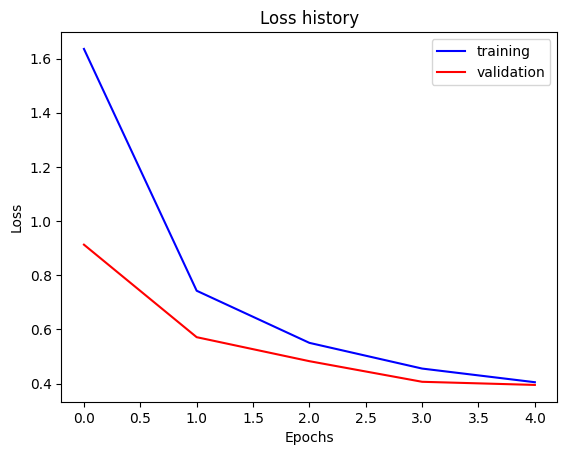

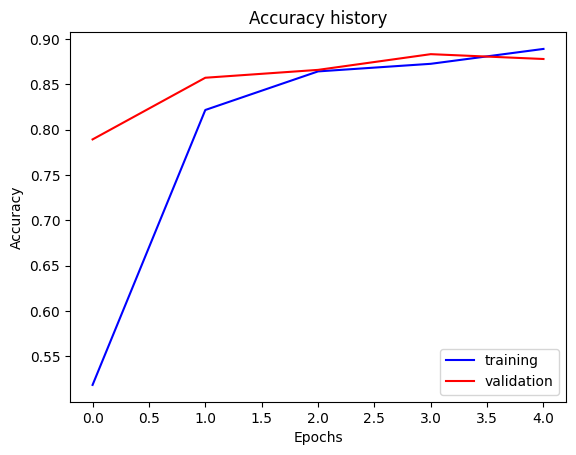

In [45]:
trainer.plot_loss_history()
trainer.plot_accuracy()

In [46]:
train_accuracy = trainer.train_accuracy_history[-1]
validation_accuracy = trainer.validation_accuracy_history[-1]
print(
    "Train Accuracy = {}; Validation Accuracy = {}".format(
        train_accuracy, validation_accuracy
    )
)

Train Accuracy = 0.8891122278056951; Validation Accuracy = 0.878


### Save Trained MyResnet18 model

In [47]:
save_trained_model_weights(my_resnet, out_dir="./")

### Part 3.3 Visualize and Analyze Confusion Matrix

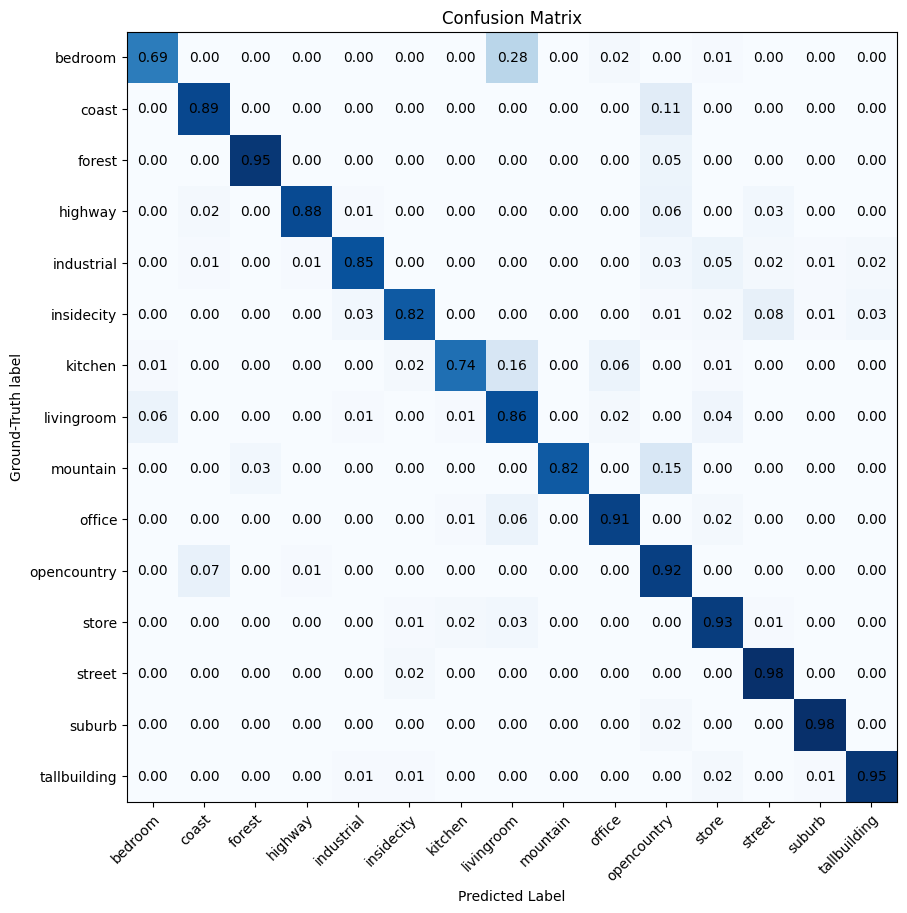

In [48]:
generate_and_plot_confusion_matrix(my_resnet, trainer.val_dataset, use_cuda=is_cuda)

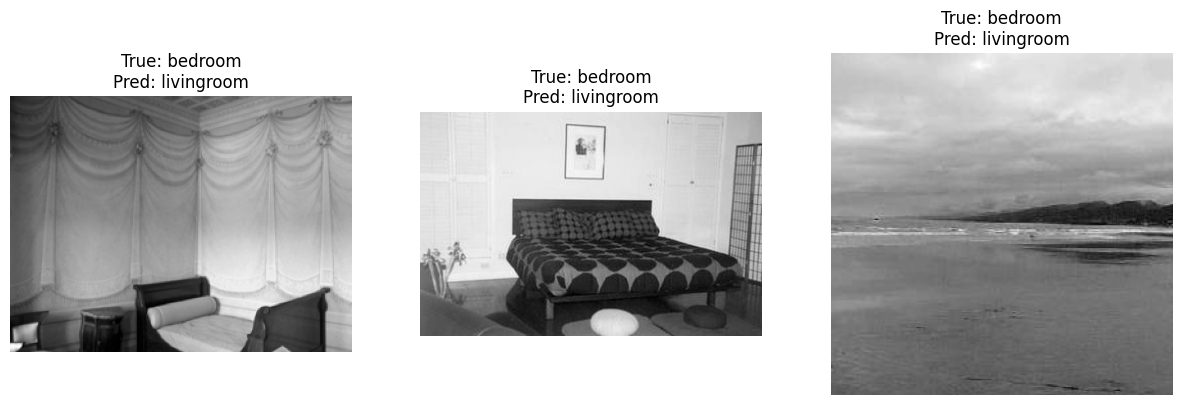

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from vision.confusion_matrix import generate_confusion_data, generate_confusion_matrix

model = trainer.model
dataset = trainer.val_dataset  # single-label ImageLoader

targets, preds, class_labels = generate_confusion_data(model, dataset, use_cuda=is_cuda)
cm = generate_confusion_matrix(np.array(targets, dtype=np.int32), np.array(preds, dtype=np.int32), len(class_labels))

# find bedroom index
bedroom_idx = None
try:
    bedroom_idx = class_labels.index('bedroom')
except ValueError:
    bedroom_idx = next((i for i, c in enumerate(class_labels) if c.lower() == 'bedroom'), None)

if bedroom_idx is None:
    print("Class 'bedroom' not found in class_labels.")
else:
    mis_idx = np.where((targets == bedroom_idx) & (preds != bedroom_idx))[0]
    if len(mis_idx) == 0:
        print("No misclassified 'bedroom' examples found in validation set.")
    else:
        n = min(3, len(mis_idx))
        fig, axes = plt.subplots(1, n, figsize=(5 * n, 5))
        if n == 1:
            axes = [axes]
        for ax, idx in zip(axes, mis_idx[:n]):
            path, _ = dataset.dataset[int(idx)]
            try:
                img = dataset.load_img_from_path(path)
            except Exception:
                from PIL import Image
                img = Image.open(path).convert('RGB')
            arr = np.asarray(img)
            if img.mode == 'L' or arr.ndim == 2:
                ax.imshow(arr, cmap='gray')
            else:
                ax.imshow(arr)
            ax.set_title(f"True: bedroom\nPred: {class_labels[int(preds[int(idx)])]}")
            ax.axis('off')
        plt.show()

# Part 4: Multilabel Classification - Scene Attribute Prediction

Thus far, our convolutional neural network models are able to classify the class of the input image. This part of the project is focused on training a model that is capable of predicting attributes in images.

A subset of the above dataset containing images only from the 'coast', 'highway', 'mountain', 'opencountry', 'street' classes will be used. Target labels are represented as binary arrays corresponding to the following attributes:
<ul>
    <li> Clouds </li>
    <li> Water body </li>
    <li> People </li>
    <li> Animals </li>
    <li> Natural </li>
    <li> Man-made </li>
    <li> Vehicles </li>
</ul>

For example, if an input image of a natural scene has clouds, people and vehicles only, we expect an output of [1, 0, 1, 0, 1, 0, 1].

## Part 4.1 & 4.2 Model Architecture & Training

In [52]:
multi_resnet = MultilabelResNet18()
print(multi_resnet)

MultilabelResNet18(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [54]:
inp_size = (224, 224)

In [ ]:
optimizer_config = {"optimizer_type": "adam", "lr": 1e-3, "weight_decay": 1e-4}

In [56]:
multi_resnet = MultilabelResNet18()
optimizer = get_optimizer(multi_resnet, optimizer_config)

trainer = MultiLabelTrainer(
    data_dir=data_path,
    model=multi_resnet,
    optimizer=optimizer,
    model_dir=os.path.join(model_path, "multilabel_resnet18"),
    train_data_transforms=get_all_transforms(inp_size, [dataset_mean], [dataset_std]),
    val_data_transforms=get_fundamental_normalization_transforms(
        inp_size, [dataset_mean], [dataset_std]
    ),
    batch_size=32,
    load_from_disk=False,
    cuda=is_cuda,
    mps=is_apple_silicon,
)

In [57]:
%%time
trainer.run_training_loop(num_epochs=10)

Epoch:1 Train Loss:0.4763 Val Loss: 0.3815 Train Accuracy: 0.7710 Validation Accuracy: 0.8411
Epoch:2 Train Loss:0.3308 Val Loss: 0.3053 Train Accuracy: 0.8718 Validation Accuracy: 0.8854
Epoch:3 Train Loss:0.2892 Val Loss: 0.2832 Train Accuracy: 0.8930 Validation Accuracy: 0.8997
Epoch:4 Train Loss:0.2660 Val Loss: 0.2736 Train Accuracy: 0.9018 Validation Accuracy: 0.8971
Epoch:5 Train Loss:0.2517 Val Loss: 0.2557 Train Accuracy: 0.9047 Validation Accuracy: 0.9074
Epoch:6 Train Loss:0.2495 Val Loss: 0.2529 Train Accuracy: 0.9049 Validation Accuracy: 0.9011
Epoch:7 Train Loss:0.2393 Val Loss: 0.2490 Train Accuracy: 0.9084 Validation Accuracy: 0.9080
Epoch:8 Train Loss:0.2320 Val Loss: 0.2429 Train Accuracy: 0.9148 Validation Accuracy: 0.9080
Epoch:9 Train Loss:0.2296 Val Loss: 0.2461 Train Accuracy: 0.9118 Validation Accuracy: 0.9074
Epoch:10 Train Loss:0.2250 Val Loss: 0.2447 Train Accuracy: 0.9114 Validation Accuracy: 0.9077
CPU times: user 23.6 s, sys: 7.78 s, total: 31.4 s
Wall tim

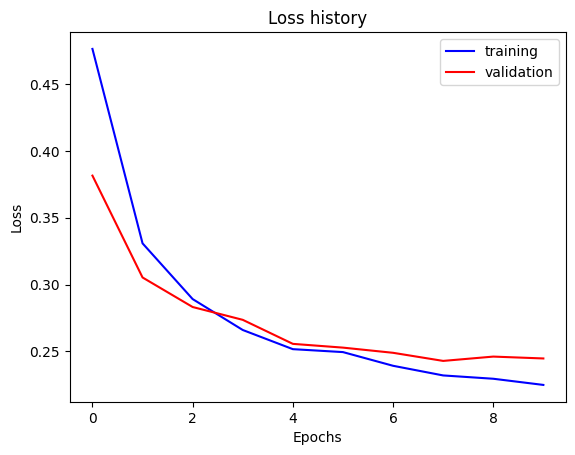

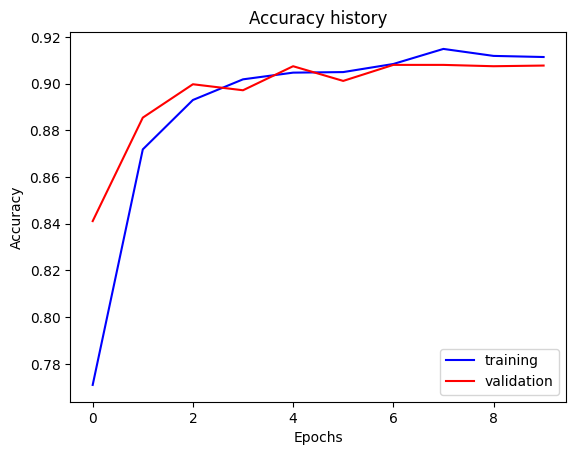

In [58]:
trainer.plot_loss_history()
trainer.plot_accuracy()

In [59]:
train_accuracy = trainer.train_accuracy_history[-1]
validation_accuracy = trainer.validation_accuracy_history[-1]
print(
    "Train Accuracy = {}; Validation Accuracy = {}".format(
        train_accuracy, validation_accuracy
    )
)

Train Accuracy = 0.9113712374581941; Validation Accuracy = 0.9077142857142858


### Save Trained MultilabelResnet18 model

In [60]:
save_trained_model_weights(multi_resnet, out_dir="./")

## 4.3 Visualize Results


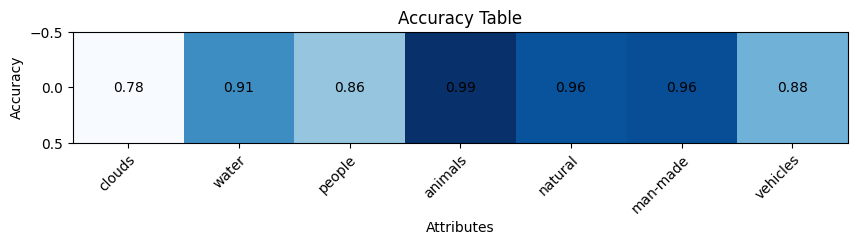

In [62]:
att_list = ['clouds', 'water', 'people', 'animals', 'natural', 'man-made', 'vehicles']

generate_and_plot_accuracy_table(
    multi_resnet, 
    trainer.val_dataset, 
    num_attributes=7,
    attribute_labels=att_list,
    use_cuda=is_cuda
)